In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [3]:
real_survey_data = pd.read_csv('/Users/liyuan/DSA3101/Final Synthetic Data Generation/survey_data_cleaned.csv')

**MRQ Question Renaming**:
To simplify analysis, original MRQ questions are mapped to shorter names:
- `what are your preferred attraction(s)? select all that apply.` → `preferred_attractions`
- `which attraction(s) did you visit? (select all that apply)` → `attractions_visited`
- `which store(s) did you visit? (select all that apply)` → `stores_visited`
- `if your answer was "yes" above, which food outlet(s) did you visit? (select all that apply)` → `food_outlets_visited`
- `which aspect of your visit was the most disappointing? (select all that apply)` → `disappointing_aspects`

**Additional Standardization**:
- **Occupation**: "Self-employed" entries are standardized to "Employed."
- **Ticket Purchase Method**: Any method outside the valid list of "Resort World Sentosa Website," "Physically at the entrance," and "Third Party Vendor (e.g. Klook, Trip.com)" is reclassified as "Others" to streamline categories.

In [4]:
# Map original MRQ questions to shorter names
mrq_rename_mapping = {
    'what are your preferred attraction(s)? select all that apply.': 'preferred_attractions',
    'which attraction(s) did you visit? (select all that apply)\n* includes meet-and-greets, theatre shows etc.': 'attractions_visited',
    'which store(s) did you visit? (select all that apply)': 'stores_visited',
    'if your answer was "yes" above, which food outlet(s) did you visit? (select all that apply)': 'food_outlets_visited',
    'which aspect of your visit was the most disappointing? (select all that apply)': 'disappointing_aspects'
}

real_survey_data.rename(columns=mrq_rename_mapping, inplace=True)

# Replace 'Self-employed' with 'Employed' in the 'occupation' column
real_survey_data['occupation'] = real_survey_data['occupation'].replace('Self-employed', 'Employed')

# Map any ticket purchase method not in the valid list to "Others"
valid_methods = [
    "Resort World Sentosa Website", 
    "Physically at the entrance", 
    "Third Party Vendor (e.g. Klook, Trip.com)"
]

real_survey_data['ticket_purchase_method'] = real_survey_data['ticket_purchase_method'].apply(lambda x: x if x in valid_methods else "Others")

# Feature Engineering Summary

The original survey dataset contained **43 features**, comprising various categorical, ordinal, numerical, and text-based responses. To prepare the data for clustering and segmentation, we performed comprehensive feature engineering, resulting in a refined set of **17 features**. Key steps included:

1. **Encoding Categorical Variables**: Converted categorical features into numerical formats via one-hot or ordinal encoding, making them suitable for clustering algorithms.

2. **Scaling Features**: Scaled all numerical features to the [0, 1] range to facilitate effective clustering, ensuring that all features contribute proportionally to the analysis.

3. **Creating Interaction Features**: Creation of various new features to capture complex guest behaviors and preferences, providing deeper insights into potential segments.

4. **Feature Selection**: Retained features most relevant to our objectives by assessing their correlation with `overall_satisfaction` and removing features with low correlation, minimal relevance to target outcomes, or significant lack of data. This reduced noise and improved model interpretability.

## Encoding and Scaling for Ordinal Features

Certain ordinal features were encoded to reflect their inherent order, with higher values indicating a more positive guest experience:

- **`return_likelihood`**: Encoded as `{No: 0, Maybe: 1, Yes: 2}` to reflect increasing likelihood of return.
- **`merchandise_spend`** and **`food_spend`**: Encoded by spending levels from `"NA"` (0) to `">$30"` (4).
- **`queue_time_at_entry`** and **`food_wait_time`**: Encoded to reflect shorter wait times with higher values (e.g., `> 20 mins` as 0, `< 5 mins` as 3), indicating better guest experience.
- **`visit_issues_resolved`**: Encoded as `{Yes, issue not resolved: 0, Yes, issue resolved: 1, No issue: 2}`, capturing resolution satisfaction.

In [5]:
ordinal_mappings = {
    'return_likelihood': {'No': 0, 'Maybe': 1, 'Yes': 2},
    'merchandise_spend': {'NA': 0, '< $10': 1, '$10 - $20': 2, '$20 - $30': 3, '>$30': 4},
    'food_spend': {'NA': 0, '< $10': 1, '$10 - $20': 2, '$20 - $30': 3, '>$30': 4},
    'queue_time_at_entry': {'> 20 mins': 0, '10 - 20 mins': 1, '5 - 10 mins': 2, '< 5 mins': 3},
    'food_wait_time': {'NA': 0, '> 10 mins': 1, '5 - 10 mins': 2, '< 5 mins': 3},  
    'visit_issues_resolved': {'Yes, issue not resolved': 0, 'Yes, issue resolved': 1, 'No issue': 2}
}

# Apply the mappings to each feature
for feature, mapping in ordinal_mappings.items():
    real_survey_data[feature] = real_survey_data[feature].map(mapping)

In [6]:
# Check for any NaN values in the columns after applying the mappings
for feature in ordinal_mappings.keys():
    na_count = real_survey_data[feature].isna().sum()
    if na_count > 0:
        print(f"Column '{feature}' has {na_count} NaN values.")
    else:
        print(f"Column '{feature}' has no NaN values.")

Column 'return_likelihood' has no NaN values.
Column 'merchandise_spend' has 55 NaN values.
Column 'food_spend' has 27 NaN values.
Column 'queue_time_at_entry' has no NaN values.
Column 'food_wait_time' has 23 NaN values.
Column 'visit_issues_resolved' has 63 NaN values.


In [7]:
# Fill NaN values with 0 by reassigning the filled columns to the DataFrame
for feature in ['merchandise_spend', 'food_spend', 'food_wait_time', 'visit_issues_resolved']:
    real_survey_data[feature] = real_survey_data[feature].fillna(0)

# Verify the changes
print(real_survey_data[['merchandise_spend', 'food_spend', 'food_wait_time', 'visit_issues_resolved']].head())

   merchandise_spend  food_spend  food_wait_time  visit_issues_resolved
0                0.0         3.0             1.0                    0.0
1                0.0         0.0             0.0                    0.0
2                0.0         3.0             2.0                    0.0
3                0.0         0.0             0.0                    0.0
4                0.0         0.0             0.0                    0.0


In [8]:
# Scale the encoded features to [0, 1] range using Min-Max Scaling
features_to_scale = list(ordinal_mappings.keys())

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the selected features and update the df
real_survey_data[features_to_scale] = scaler.fit_transform(real_survey_data[features_to_scale])

real_survey_data[features_to_scale].head()

,return_likelihood,merchandise_spend,food_spend,queue_time_at_entry,food_wait_time,visit_issues_resolved
0,0.5,0.0,1.0,0.333333,0.333333,0.0
1,1.0,0.0,0.0,0.333333,0.000000,0.0
2,1.0,0.0,1.0,1.000000,0.666667,0.0
3,1.0,0.0,0.0,0.333333,0.000000,0.0
4,0.5,0.0,0.0,0.666667,0.000000,0.0


## Encoding and Scaling for Binary Features

**`park_seating_availability`** and **`recommendation_likelihood`** are encoded as `1` (Yes) and `0` (No) to use them as clustering features alongside other scaled numerical values. These features reflect guest satisfaction indicators, making them comparable to satisfaction scores in clustering.

In contrast, **`visitor_profile`** (Singaporean/Tourist) and **`special_event_ticket`** (Yes/No) represent categorical distinctions rather than quality indicators, so they were excluded from scaling to avoid adding irrelevant distance measures to the clustering process.


In [9]:
# Convert binary features to 1 and 0 for clustering
real_survey_data['park_seating_availability'] = real_survey_data['park_seating_availability'].map({'Yes': 1, 'No': 0})
real_survey_data['recommendation_likelihood'] = real_survey_data['recommendation_likelihood'].map({'Yes': 1, 'No': 0})

real_survey_data[['park_seating_availability', 'recommendation_likelihood']].head()

,park_seating_availability,recommendation_likelihood
0,1,1
1,1,1
2,0,1
3,1,1
4,0,1


## Scaling for Numerical Features 

In [10]:
rating_features = [
    'ticket_purchase_ease', 'arrival_experience', 'attraction_wait_time', 
    'express_pass_satisfaction', 'attraction_staff_service', 'attraction_overall_experience', 
    'merchandise_price_reasonable', 'merchandise_variety', 'food_variety', 
    'food_quality', 'food_price_reasonable', 'overall_staff_service', 
    'park_cleanliness', 'restroom_accessibility', 'overall_satisfaction'
]

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the rating features and update the df
real_survey_data[rating_features] = scaler.fit_transform(real_survey_data[rating_features])

real_survey_data[rating_features].head()

,ticket_purchase_ease,arrival_experience,attraction_wait_time,express_pass_satisfaction,attraction_staff_service,attraction_overall_experience,merchandise_price_reasonable,merchandise_variety,food_variety,food_quality,food_price_reasonable,overall_staff_service,park_cleanliness,restroom_accessibility,overall_satisfaction
0,0.75,0.50,0.50,0.666667,0.75,0.50,0.25,0.50,0.50,0.50,0.25,0.75,0.75,0.75,0.75
1,0.75,1.00,1.00,NaN,1.00,1.00,0.50,0.50,1.00,0.50,0.25,1.00,1.00,1.00,1.00
2,1.00,1.00,0.25,NaN,0.50,1.00,0.75,1.00,0.50,0.75,0.25,0.50,0.50,0.25,0.75
3,0.50,0.75,0.25,NaN,0.75,0.75,0.25,0.50,0.50,0.50,0.25,0.75,0.75,0.75,0.75
4,1.00,0.75,0.75,NaN,0.75,0.75,0.25,0.75,0.25,0.50,0.25,0.75,0.75,0.75,0.50


## Dropping of Features

In [11]:
# Count columns with NA values and display the column names with the count of NA entries
na_counts = real_survey_data.isna().sum()
na_columns = na_counts[na_counts > 0]

# Count of respondents who answered "No" for "used_express_pass", "shopping_purchase", and "food_purchase"
no_express_pass_count = (real_survey_data['used_express_pass'] == 'No').sum()
no_shopping_purchase_count = (real_survey_data['shopping_purchase'] == 'No').sum()
no_food_purchase_count = (real_survey_data['food_purchase'] == 'No').sum()

# Display results
print(f"Number of columns containing NA values: {len(na_columns)}")
print("Columns with NA values and their counts:")
print(na_columns)
print(f"\nNumber of respondents who answered 'No' for 'used_express_pass': {no_express_pass_count}")
print(f"Number of respondents who answered 'No' for 'shopping_purchase': {no_shopping_purchase_count}")
print(f"Number of respondents who answered 'No' for 'food_purchase': {no_food_purchase_count}")

Number of columns containing NA values: 5
Columns with NA values and their counts:
express_pass_satisfaction    65
stores_visited               38
food_outlets_visited         25
disappointing_aspects         6
additional_comments          13
dtype: int64

Number of respondents who answered 'No' for 'used_express_pass': 65
Number of respondents who answered 'No' for 'shopping_purchase': 50
Number of respondents who answered 'No' for 'food_purchase': 27


In [12]:
# Drop redundant binary features
real_survey_data = real_survey_data.drop(columns=['food_purchase', 'shopping_purchase'])

# Drop text features for clustering
real_survey_data = real_survey_data.drop(columns=['additional_comments'])

# Drop due to significant lack of data
real_survey_data = real_survey_data.drop(columns=['used_express_pass', 'express_pass_satisfaction', 'food_wait_time'])

We retained `overall_staff_service` and `attraction_overall_experience` as primary indicators for staff and attraction satisfaction, while dropping related features:
  - `overall_staff_service` effectively captures guest sentiment toward staff, making **`attraction_staff_service` and `entry_staff_service`** redundant.
  - `attraction_overall_experience` provides a direct measure of attraction enjoyment and quality, allowing us to omit **`attraction_staff_service` and `attraction_wait_time`**.

In [13]:
real_survey_data = real_survey_data.drop(columns=['attraction_staff_service', 'entry_staff_service', 'attraction_wait_time'])

Dropping **`visit_month`** and **`visit_day`**

We’re removing `visit_month` and `visit_day` to simplify the dataset, as seasonal patterns will be analyzed later in the project.

In [14]:
real_survey_data = real_survey_data.drop(columns=['visit_month', 'visit_day'])

## Creating Interaction Features

### 1. **`food_shopping_satisfaction_score`**

**Components**: `food_quality`, `food_variety`, `food_price_reasonable`, `merchandise_variety`, `merchandise_price_reasonable`

**Calculation**: The score is computed as a **weighted average** of the five components. Weights are determined based on each component's correlation with `overall_satisfaction`, assigning higher weights to components with stronger relationships to guest satisfaction. 

**Purpose**: This score aggregates guest satisfaction related to food and retail options within the park, offering insights into preferences for quality, variety, and price.

In [15]:
# Calculate individual correlations with overall_satisfaction
correlation_food_quality = real_survey_data['food_quality'].corr(real_survey_data['overall_satisfaction'])
correlation_food_variety = real_survey_data['food_variety'].corr(real_survey_data['overall_satisfaction'])
correlation_food_price = real_survey_data['food_price_reasonable'].corr(real_survey_data['overall_satisfaction'])
correlation_merchandise_variety = real_survey_data['merchandise_variety'].corr(real_survey_data['overall_satisfaction'])
correlation_merchandise_price = real_survey_data['merchandise_price_reasonable'].corr(real_survey_data['overall_satisfaction'])

# Sum of absolute correlations
total_correlation_food_shopping = (
    abs(correlation_food_quality) +
    abs(correlation_food_variety) +
    abs(correlation_food_price) +
    abs(correlation_merchandise_variety) +
    abs(correlation_merchandise_price)
)

# Calculate proportional weights
weight_food_quality = abs(correlation_food_quality) / total_correlation_food_shopping
weight_food_variety = abs(correlation_food_variety) / total_correlation_food_shopping
weight_food_price = abs(correlation_food_price) / total_correlation_food_shopping
weight_merchandise_variety = abs(correlation_merchandise_variety) / total_correlation_food_shopping
weight_merchandise_price = abs(correlation_merchandise_price) / total_correlation_food_shopping

# Calculate the weighted food_shopping_satisfaction_score
real_survey_data['weighted_food_shopping_satisfaction_score'] = (
    weight_food_quality * real_survey_data['food_quality'] +
    weight_food_variety * real_survey_data['food_variety'] +
    weight_food_price * real_survey_data['food_price_reasonable'] +
    weight_merchandise_variety * real_survey_data['merchandise_variety'] +
    weight_merchandise_price * real_survey_data['merchandise_price_reasonable']
)

# Drop the original columns 
real_survey_data = real_survey_data.drop(columns=['food_quality', 'food_variety', 'food_price_reasonable', 'merchandise_variety', 'merchandise_price_reasonable'])

real_survey_data['weighted_food_shopping_satisfaction_score'].head()

0    0.420844
1    0.571141
2    0.685033
3    0.420844
4    0.429581
Name: weighted_food_shopping_satisfaction_score, dtype: float64

### 2. **`total_spend`**

**Components**: `merchandise_spend`, `food_spend`

**Calculation**: `total_spend` is computed as the sum of `merchandise_spend` and `food_spend`.

**Purpose**: This feature provides an aggregate view of guest spending behavior, combining both merchandise and food expenditures. It offers insights into overall spending levels, allowing for more streamlined analysis and segmentation of guests based on total expenditure within the park.


In [16]:
real_survey_data['total_spend'] = real_survey_data['merchandise_spend'] + real_survey_data['food_spend']

# Drop the original columns
real_survey_data.drop(columns=['merchandise_spend', 'food_spend'], inplace=True)

real_survey_data['total_spend'].head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: total_spend, dtype: float64

### 3. **`amenities_satisfaction_score`**

**Components**: `park_cleanliness`, `restroom_accessibility`, `park_seating_availability`

**Calculation**: The score is computed as a **weighted average** of the three components. Weights are based on each component’s correlation with `overall_satisfaction`, giving higher importance to aspects more strongly linked to guest satisfaction. For instance, **`park_cleanliness`** and **`restroom_accessibility`** are assigned higher weights since they are more closely associated with `overall_satisfaction`.

**Purpose**: This score provides an aggregated view of guest satisfaction with park amenities that contribute to the guest experience, focusing on cleanliness, restroom accessibility, and seating availability.

In [17]:
# Calculate individual correlations with overall_satisfaction
correlation_cleanliness = real_survey_data['park_cleanliness'].corr(real_survey_data['overall_satisfaction'])
correlation_restroom = real_survey_data['restroom_accessibility'].corr(real_survey_data['overall_satisfaction'])
correlation_seating = real_survey_data['park_seating_availability'].corr(real_survey_data['overall_satisfaction'])

# Sum of absolute correlations
total_correlation = abs(correlation_cleanliness) + abs(correlation_restroom) + abs(correlation_seating)

# Calculate proportional weights
weight_cleanliness = abs(correlation_cleanliness) / total_correlation
weight_restroom = abs(correlation_restroom) / total_correlation
weight_seating = abs(correlation_seating) / total_correlation

# Calculate the weighted amenities satisfaction score
real_survey_data['weighted_amenities_satisfaction_score'] = (
    weight_cleanliness * real_survey_data['park_cleanliness'] +
    weight_restroom * real_survey_data['restroom_accessibility'] +
    weight_seating * real_survey_data['park_seating_availability']
)

# Drop the original columns
real_survey_data = real_survey_data.drop(columns=['park_cleanliness', 'restroom_accessibility', 'park_seating_availability'])

real_survey_data['weighted_amenities_satisfaction_score'].head()

0    0.795264
1    1.000000
2    0.310502
3    0.795264
4    0.614207
Name: weighted_amenities_satisfaction_score, dtype: float64

### 4. **`entry_experience_score`**

**Components**: `arrival_experience`, `ticket_purchase_ease`, `queue_time_at_entry`

**Calculation**: The score is computed as a **weighted average** of the three components. Weights are based on each component’s correlation with `overall_satisfaction`, giving more emphasis to aspects with stronger relationships to guest satisfaction. For example, **`arrival_experience`** receive the highest weight as it has the highest correlation score with `overall_satisfaction` (0.75).

**Purpose**: This weighted score provides an aggregated view of the guest’s entry experience, emphasizing the most impactful aspects of the entry process to better understand and improve entry efficiency.

In [19]:
# Calculate individual correlations with overall_satisfaction
correlation_arrival_experience = real_survey_data['arrival_experience'].corr(real_survey_data['overall_satisfaction'])
correlation_ticket_purchase_ease = real_survey_data['ticket_purchase_ease'].corr(real_survey_data['overall_satisfaction'])
correlation_queue_time = real_survey_data['queue_time_at_entry'].corr(real_survey_data['overall_satisfaction'])

# Sum of absolute correlations
total_correlation_entry_experience = (
    abs(correlation_arrival_experience) +
    abs(correlation_ticket_purchase_ease) +
    abs(correlation_queue_time)
)

# Calculate proportional weights
weight_arrival_experience = abs(correlation_arrival_experience) / total_correlation_entry_experience
weight_ticket_purchase_ease = abs(correlation_ticket_purchase_ease) / total_correlation_entry_experience
weight_queue_time = abs(correlation_queue_time) / total_correlation_entry_experience

print("Calculated weights based on correlation:")
print(f"arrival_experience weight: {weight_arrival_experience:.2f}")
print(f"ticket_purchase_ease weight: {weight_ticket_purchase_ease:.2f}")
print(f"queue_time_at_entry weight: {weight_queue_time:.2f}")

# Calculate the weighted entry experience score
real_survey_data['weighted_entry_experience_score'] = (
    weight_arrival_experience * real_survey_data['arrival_experience'] +
    weight_ticket_purchase_ease * real_survey_data['ticket_purchase_ease'] +
    weight_queue_time * real_survey_data['queue_time_at_entry']
)

# Drop the original columns
real_survey_data.drop(columns=['arrival_experience', 'ticket_purchase_ease', 'queue_time_at_entry'], inplace=True)

real_survey_data['weighted_entry_experience_score'].head()

Calculated weights based on correlation:
arrival_experience weight: 0.45
ticket_purchase_ease weight: 0.34
queue_time_at_entry weight: 0.21


0    0.550677
1    0.776780
2    1.000000
3    0.578543
4    0.817931
Name: weighted_entry_experience_score, dtype: float64

### 5. **`engagement_level`**
**Components**: Number of attractions visited from MRQ question `attractions_visited`

**Calculation**: Guests are categorized into **High (> 10 attractions)**, **Moderate (6-9 attractions)**, and **Low (< 6 attractions)** engagement levels. The engagement levels are ordinally encoded as `High = 2`, `Moderate = 1`, and `Low = 0`, then scaled to the `[0, 1]` range using MinMaxScaler.

**Purpose**: This feature quantifies visitor engagement intensity, with higher values indicating more active guests. It provides insight into guest behavior patterns, distinguishing between more engaged "explorers" and less engaged "relaxed visitors."

In [20]:
# Convert 'attractions_visited' from strings to lists and count the number of attractions
real_survey_data['attractions_visited'] = real_survey_data['attractions_visited'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
real_survey_data['num_attractions_visited'] = real_survey_data['attractions_visited'].apply(len)

def categorize_engagement(count):
    if count >= 10:
        return 'High'
    elif count >= 6:
        return 'Moderate'
    else:
        return 'Low'

real_survey_data['engagement_level'] = real_survey_data['num_attractions_visited'].apply(categorize_engagement)

# Ordinal encoding 
engagement_mapping = {'High': 2, 'Moderate': 1, 'Low': 0}
real_survey_data['engagement_level'] = real_survey_data['engagement_level'].map(engagement_mapping)

# apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
real_survey_data[['engagement_level']] = scaler.fit_transform(real_survey_data[['engagement_level']])

real_survey_data = real_survey_data.drop(columns=['num_attractions_visited'])

real_survey_data['engagement_level'].head()

0    1.0
1    1.0
2    0.0
3    1.0
4    0.5
Name: engagement_level, dtype: float64

### 6. **`disappointment_level`**
**Components**: Number of disappointing aspects reported by guests from MRQ question `disappointing_aspects`

**Calculation**: Guests are categorized into **High (4 or more issues)**, **Moderate (2-3 issues)**, and **Low (1 or no issues)** disappointment levels. The levels are ordinally encoded as `High = 2`, `Moderate = 1`, and `Low = 0`, then scaled to the `[0, 1]` range using MinMaxScaler.

**Purpose**: This feature quantifies the level of dissatisfaction a guest experienced during their visit, with higher values indicating more reported issues. It provides insight into potential pain points for each guest, helping to identify areas that may negatively impact overall satisfaction and guest experience.


In [21]:
# Convert 'disappointing_aspects' from strings to lists and count the number of aspects
real_survey_data['disappointing_aspects'] = real_survey_data['disappointing_aspects'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
real_survey_data['num_disappointing_aspects'] = real_survey_data['disappointing_aspects'].apply(len)

# Define a function to categorize disappointment level
def categorize_disappointment(count):
    if count >= 4:
        return 'High'
    elif count >= 2:
        return 'Moderate'
    else:
        return 'Low'
        
# Apply the function to categorize disappointment level
real_survey_data['disappointment_level'] = real_survey_data['num_disappointing_aspects'].apply(categorize_disappointment)

# Ordinal encoding for disappointment level
disappointment_mapping = {'High': 2, 'Moderate': 1, 'Low': 0}
real_survey_data['disappointment_level'] = real_survey_data['disappointment_level'].map(disappointment_mapping)

# Scale disappointment level to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
real_survey_data[['disappointment_level']] = scaler.fit_transform(real_survey_data[['disappointment_level']])

real_survey_data = real_survey_data.drop(columns=['num_disappointing_aspects'])

real_survey_data['disappointment_level'].head()

0    0.5
1    0.0
2    0.5
3    0.0
4    0.5
Name: disappointment_level, dtype: float64

### 7. **`thrill_seeker_level`**
**Components**: Number of thrill attractions visited by guests from the MRQ question `attractions_visited`

**Calculation**: Guests are categorized into High (3 or more thrill rides), Moderate (1-2 thrill rides), and Low (0 thrill rides) thrill-seeking levels. The levels are ordinally encoded as High = 2, Moderate = 1, and Low = 0, then scaled to the `[0, 1]` range using MinMaxScaler.

**Purpose**: This feature identifies guests with a preference for high-intensity thrill attractions. Higher values indicate stronger thrill-seeking behavior, providing insights into guest preferences and helping to personalize experiences for thrill-seekers versus family-oriented or relaxed visitors.

In [22]:
# Define the list of thrill attractions with exact names as they appear in the data
thrill_attractions = [
    "[Ancient Egypt] Revenge of the Mummy", 
    "[Sci-Fi City] TRANSFORMERS The Ride: The Ultimate 3D Battle",
    "[Sci-Fi City] Battlestar Galactica: HUMAN vs CYLON", 
    "[The Lost World] Jurassic Park Rapid Adventure", 
    "[Far Far Away] Enchanted Airways"
]

# Count thrill attractions visited by each guest
real_survey_data['num_thrill_attractions'] = real_survey_data['attractions_visited'].apply(lambda x: sum(1 for attraction in x if attraction in thrill_attractions))

# Function to categorize thrill-seeking level based on the count of thrill attractions
def categorize_thrill_seeker(count):
    if count >= 3:
        return 'High'
    elif count >= 1:
        return 'Moderate'
    else:
        return 'Low'

# Apply the function to categorize thrill-seeking level
real_survey_data['thrill_seeker_level'] = real_survey_data['num_thrill_attractions'].apply(categorize_thrill_seeker)

# Ordinal encoding 
thrill_seeker_mapping = {'High': 2, 'Moderate': 1, 'Low': 0}
real_survey_data['thrill_seeker_level'] = real_survey_data['thrill_seeker_level'].map(thrill_seeker_mapping)

# Scale thrill-seeker level to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
real_survey_data[['thrill_seeker_level']] = scaler.fit_transform(real_survey_data[['thrill_seeker_level']])

# Drop intermediate column 
real_survey_data = real_survey_data.drop(columns=['num_thrill_attractions'])

real_survey_data['thrill_seeker_level'].head()

0    1.0
1    1.0
2    0.5
3    1.0
4    0.5
Name: thrill_seeker_level, dtype: float64

### Justification for Dropping MRQ Columns

To simplify analysis while retaining key insights, the 5 MRQ columns are dropped due to engineered features that capture the necessary information more effectively:

1. **`preferred_attractions`**
   - The `preferred_attractions` feature is removed in favor of using `attractions_visited`, which provides a more accurate basis for segmenting guests. `attractions_visited` reflects actual behaviors within the park rather than stated preferences, offering a stronger foundation for insights. 

2. **`attractions_visited`**
   - **Original Data**: Detailed list of attractions (up to 21).
   - **Replacement Features**: `thrill_seeker_level` and `engagement_level`
     - **Purpose**: Together, these features assess guests' preference for thrill attractions and engagement level.
   - **Justification**: `thrill_seeker_level` and `engagement_level` provide a comprehensive view of visitor engagement, so `attractions_visited` is unnecessary.

3. **`disappointing_aspects`**
   - **Original Data**: Specific disappointing factors like Long Wait Times, Overcrowded Attractions.
   - **Replacement Feature**: `disappointment_level`
     - **Purpose**: Measures overall dissatisfaction based on the number of disappointing aspects reported.
   - **Justification**: `disappointment_level` summarizes dissatisfaction effectively, so dropping `disappointing_aspects` avoids excessive detail.

4. **`stores_visited` and `food_outlets_visited`**
   - **Original Data**: Lists of specific stores (up to 9) and food outlets (up to 15).
   - **Replacement Feature**: `total_spend`
     - **Purpose**: Combines merchandise and food spending to capture overall spending behavior.
   - **Justification**: Simplifying analysis by focusing on `total_spend` allows for a high-level view of guest spending behavior, facilitating further clustering algorithms.

In [23]:
# Drop the MRQ columns
real_survey_data = real_survey_data.drop(columns=[
    'preferred_attractions', 
    'attractions_visited', 
    'disappointing_aspects', 
    'stores_visited', 
    'food_outlets_visited'
])

### Age Grouping

**Categories**:
- **Children**: `< 18`
- **Young Adults**: `18 - 35`
- **Middle-Aged Adults**: `36 - 55`
- **Seniors**: `> 55`

**Purpose**: This simplified age grouping captures key visitor demographics relevant to park behavior and preferences. By focusing on broader categories, we can effectively analyze patterns in guest interests, spending, and attraction choices without unnecessary complexity.


In [24]:
# Define a simplified mapping for age ranges to fewer demographic categories
age_mapping = {
    '< 18': 'Children',
    '18 - 25': 'Young Adults',
    '26 - 35': 'Young Adults',
    '36 - 45': 'Middle-Aged Adults',
    '46 - 55': 'Middle-Aged Adults',
    '> 55': 'Seniors'
}

# Map the age feature to the new categories
real_survey_data['age_group'] = real_survey_data['age'].map(age_mapping)

real_survey_data = real_survey_data.drop(columns=['age'])

real_survey_data['age_group'].head()

0    Young Adults
1    Young Adults
2    Young Adults
3    Young Adults
4    Young Adults
Name: age_group, dtype: object

## Correlation Check

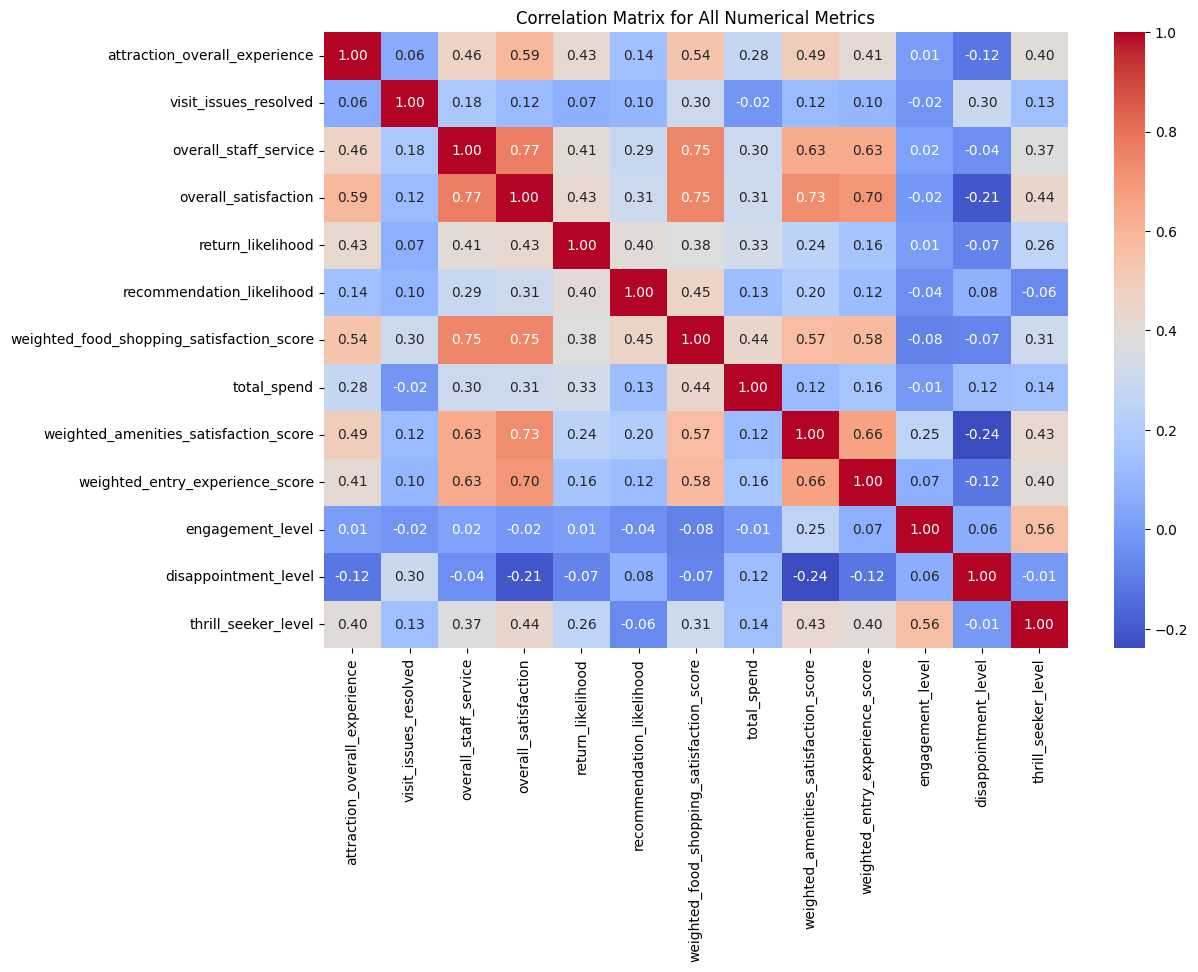

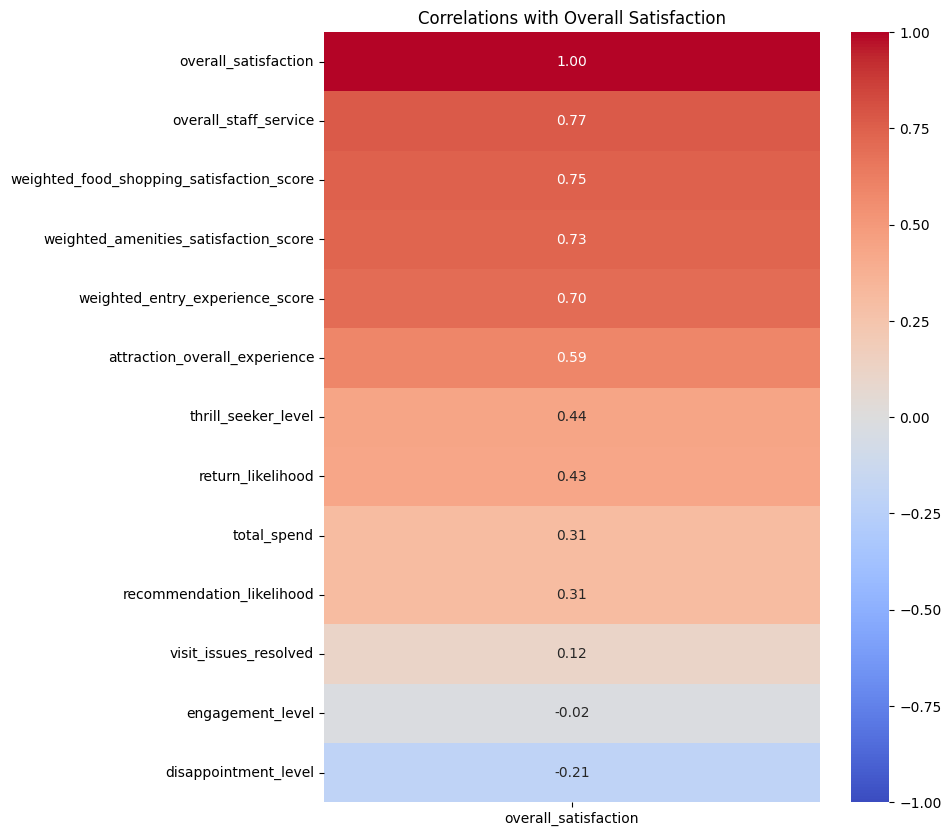

In [25]:
# Select only the numerical columns for correlation analysis
numerical_columns = real_survey_data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for All Numerical Metrics")
plt.show()

# Filter to keep only the `overall_satisfaction` row in the correlation matrix
overall_satisfaction_corr = correlation_matrix[['overall_satisfaction']].sort_values(by='overall_satisfaction', ascending=False)
return_likelihood_corr = correlation_matrix[['return_likelihood']].sort_values(by='return_likelihood', ascending=False)
total_spend_corr = correlation_matrix[['total_spend']].sort_values(by='total_spend', ascending=False)

# Plotting the focused correlation heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(overall_satisfaction_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", cbar=True)
plt.title("Correlations with Overall Satisfaction")
plt.show()

### Dropping Low-Correlation Features

To streamline the clustering process and focus on key drivers of guest satisfaction, we removed features with low correlation to `overall_satisfaction`. These features, namely `visit_issues_resolved`, `engagement_level`, `disappointment_level`, and `recommendation_likelihood`, showed minimal impact on overall satisfaction.

### Retaining Moderate-Correlation Features

While `thrill_seeker_level`, `return_likelihood`, and `total_spend` have moderate correlations with `overall_satisfaction`, they are retained for their importance in identifying distinct guest segments and their direct relevance to revenue growth.

- **Thrill Seeker Level**: Identifies guests interested in thrill-based upselling.
- **Return Likelihood**: Assists in retention-focused strategies.
- **Total Spend**: Targets high-spending guests with personalized offers.

In [26]:
real_survey_data = real_survey_data.drop(columns=['visit_issues_resolved', 'engagement_level', 'disappointment_level', 'recommendation_likelihood'])

In [27]:
real_survey_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   gender                                     69 non-null     object 
 1   occupation                                 69 non-null     object 
 2   visitor_profile                            69 non-null     object 
 3   ticket_purchase_method                     69 non-null     object 
 4   ticket_type                                69 non-null     object 
 5   special_event_ticket                       69 non-null     object 
 6   visitor_type                               69 non-null     object 
 7   attraction_overall_experience              69 non-null     float64
 8   overall_staff_service                      69 non-null     float64
 9   overall_satisfaction                       69 non-null     float64
 10  return_likelihood           

In [29]:
real_survey_data.to_csv('survey_data_17features.csv', index=False)